# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) The libraries needed to run this file. Except for numpy, scikit-learn, pandas, matplotlib

Your peers should be able to use the readme section for instructions and be able to run this file. 

Make sure to keep your answers concise. Maximum number of words is 1000, which you can count with the code below. (You can add around 600 words since we start at around 400).

In [101]:
import random

# If this cell does not work try running `pip install nbformat`

import nbformat

nb = nbformat.read("Lab1-2021.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 1003


## Group Number :31

## Student 1 
### Name :Yuqian Song
### ID :4630521

## Student 2
### Name : Akash Amalan
### ID : 4682505

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## 1. Visualization task – 1 A4

### 1a. Plot visulations

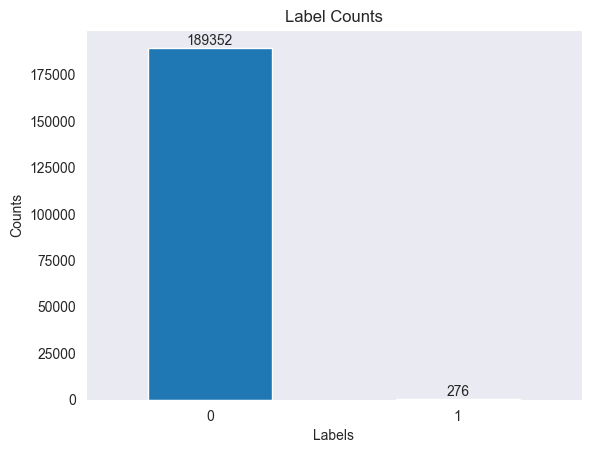

In [103]:

import re
from sklearn.preprocessing import LabelEncoder

pd_data = pd.read_csv('train_data.csv')
data = "train_data.csv"
df1 = pd.read_csv(data)

#Prepare card id and ip id for plotting
# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df1['card_id'])
df1['card_id'] = card_enc.transform(df1.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df1['ip_id'])
df1['ip_id'] = ip_enc.transform(df1.ip_id)

#Encoding, Cleaning the data
df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

unique_issuer_cc = df1['issuercountrycode'].unique()
unique_shopper_cc = df1['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
enc = LabelEncoder()
enc.fit(unique_codes)
df1['issuercountrycode'] = enc.transform(df1.issuercountrycode)
df1['shoppercountrycode'] = enc.transform(df1.shoppercountrycode)


def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)


enc1 = LabelEncoder()
enc1.fit(df1['txvariantcode'])
df1['txvariantcode'] = enc1.transform(df1.txvariantcode)

enc2 = LabelEncoder()
enc2.fit(df1['currencycode'])
df1['currencycode'] = enc2.transform(df1.currencycode)

enc3 = LabelEncoder()
enc3.fit(df1['shopperinteraction'])
df1['shopperinteraction'] = enc3.transform(df1.shopperinteraction)

df1['accountcode'] = df1['accountcode'].apply(lambda x: re.sub('Account','',x))
df1['accountcode_cc'] = 0
df1.loc[(df1['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df1.loc[(df1['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df1.loc[(df1['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df1.loc[(df1['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

enc4 = LabelEncoder()
enc4.fit(df1['accountcode'])
df1['accountcode'] = enc4.transform(df1.accountcode)

enc5 = LabelEncoder()
enc5.fit(df1['cardverificationcodesupplied'])
df1['cardverificationcodesupplied'] = enc5.transform(df1.cardverificationcodesupplied)

df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

enc6 = LabelEncoder()
enc6.fit(df1['mail_id'])
df1['mail_id'] = enc6.transform(df1.mail_id)

df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

#Feature Engineering
df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1


df = df1[['issuercountrycode','txvariantcode','bin','amount','currencycode','shoppercountrycode','shopperinteraction','cardverificationcodesupplied','cvcresponsecode','accountcode','mail_id','ip_id','card_id','amount_eur','countries_equal']]


data = df.to_numpy()
features = data[:,:-1]
labels = data[:, -1]




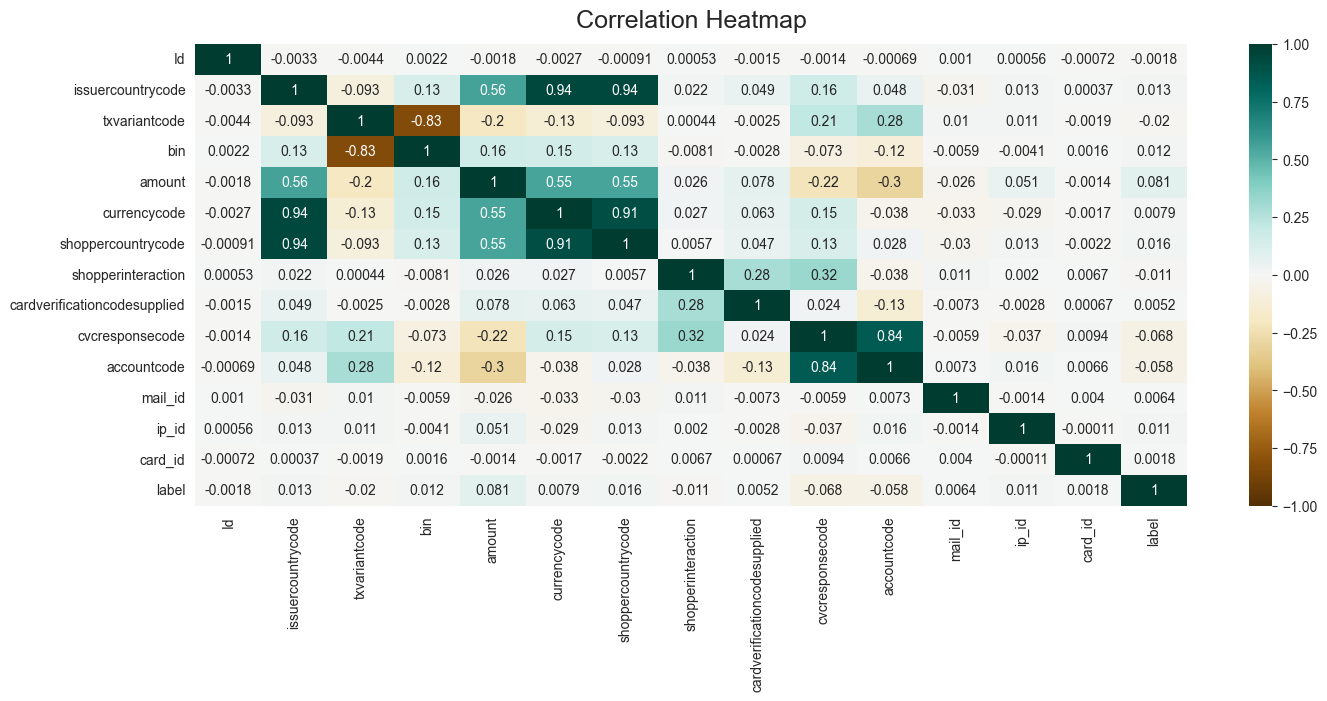

In [104]:

data_converted = pd_data.copy()
data_converted['issuercountrycode']=data_converted['issuercountrycode'].astype('category').cat.codes
data_converted['txvariantcode']=data_converted['txvariantcode'].astype('category').cat.codes
data_converted['currencycode']=data_converted['currencycode'].astype('category').cat.codes
data_converted['shoppercountrycode']=data_converted['shoppercountrycode'].astype('category').cat.codes
data_converted['shopperinteraction']=data_converted['shopperinteraction'].astype('category').cat.codes
data_converted['cardverificationcodesupplied']=data_converted['cardverificationcodesupplied'].astype('category').cat.codes
data_converted['cvcresponsecode']=data_converted['cvcresponsecode'].astype('category').cat.codes
data_converted['accountcode']=data_converted['accountcode'].astype('category').cat.codes
data_converted['mail_id']=data_converted['mail_id'].astype('category').cat.codes
data_converted['ip_id']=data_converted['ip_id'].astype('category').cat.codes
data_converted['card_id']=data_converted['card_id'].astype('category').cat.codes


unique, counts = np.unique(labels, return_counts=True)

ax = pd_data["label"].value_counts().plot(kind='bar', title='Label Counts', rot=0, grid=False)
ax.set_xlabel("Labels")
ax.set_ylabel("Counts")

for container in ax.containers:
    ax.bar_label(container)


plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data_converted.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);



[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [15] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [15] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[6]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
     PC                       feature       loading  type
0   PC1                            Id -9.999956e-01  best
1   PC2                       card_id -9.616774e-01  best
2   PC3                       mail_id -7.326491e-01  best
3   PC4                         ip

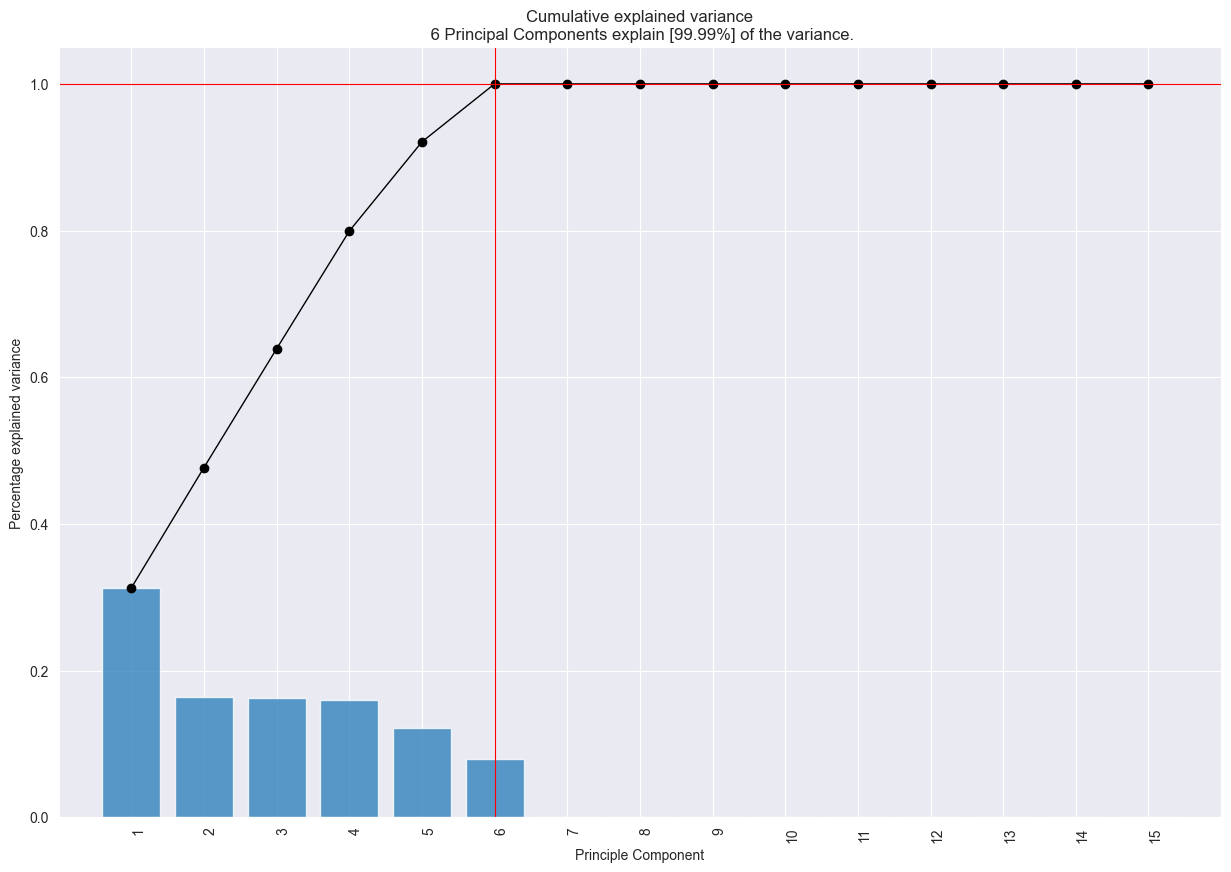

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 6 Principal Components explain [99.99%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 640x480 with 0 Axes>

In [105]:
from pca import pca

data_pca= data_converted.copy(deep=True)
data_pca.drop(columns=['label'])
model = pca()
out = model.fit_transform(data_pca)

print(out['topfeat'])
# Fit transform
model.plot()

### 1b. Describe the visualizations and provide relavant explanations of features and relations.

## 2. Imbalance task – 1 A4 – Individual

In [106]:
from numpy import interp
from sklearn.metrics import precision_recall_curve, auc, f1_score
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import __all__
from sklearn.ensemble import StackingClassifier
from scipy.spatial import KDTree
import numpy as np

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


class SMOTE:
    def __init__(self, sampling_strategy=0.1, k =5, random_state=None):

        """
        Initializes Smote
        :param sampling_strategy:  fraction *  Samples of Majority
        :param N: The paper uses smote N%, I use a sampling strategy similar to that of IMBLEARN.
        :param k: Number of nearest Neighbours
        """
        self.sampling_strategy = sampling_strategy
        self.k = k
        self.random_state = random_state if random_state is not None else np.random.RandomState()

        if sampling_strategy > 1:
             raise Exception("sampling_strategy cannot be more than 1")


    def fit_resample(self, X, y):
        # Identify the minority and majority class
        unique, counts = np.unique(y, return_counts=True)
        majority_class = unique[np.argmax(counts)]
        minority_class = unique[np.argmin(counts)]

        minority_samples = X[y == minority_class]
        majority_samples = X[y == majority_class]

        # Calculate the number of new synthetic samples(either using sampling strategy or without
        if isinstance(self.sampling_strategy, float):
            n_samples = int(len(majority_samples) * self.sampling_strategy) - len(minority_samples)
        else:
            n_samples = len(majority_samples)


        # Find k nearest neighbors of each minority sample (KDTree is efficient datastructure)
        kdtree = KDTree(minority_samples)

        # Generate synthetic samples
        synthetic_samples = []
        for i in range(n_samples):
            # Choose a random minority sample
            sample = minority_samples[self.random_state.randint(len(minority_samples))]

            # Choose a random one of its k nearest neighbors
            distances, neighbors = kdtree.query([sample], self.k)
            neighbor = minority_samples[self.random_state.choice(neighbors[0])]

            # Create a synthetic sample at a random point between the two as per slides
            synthetic_sample = sample + self.random_state.random() * (neighbor - sample)
            synthetic_samples.append(synthetic_sample)

        # Combine the original samples with the synthetic ones (attempt to get same number of samples in each class)

        X_res = np.vstack([X, np.array(synthetic_samples)])
        y_res = np.hstack([y, np.repeat(minority_class, n_samples)])


        return X_res, y_res

In [ ]:
class Trainer:

    def __init__(self, random_state= 30):
        self.random_state = random_state
        self.svc = svm.LinearSVC(random_state= self.random_state, dual = True, max_iter=2000)
        self.rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1,  random_state= self.random_state)
        self.lr = LogisticRegression(solver = 'newton-cholesky',  C = 100, n_jobs=-1, random_state= self.random_state)
        self.black_box = BaggingClassifier(estimator=t.lr, n_estimators=10, random_state=200, n_jobs=-1)
        self.white_box = self.lr

    def plot_sklearn_roc_curve(self, y_real, y_pred, title):
        fpr, tpr, _ = roc_curve(y_real, y_pred)
        roc_auc = roc_auc_score(y_real, y_pred)  # Calculate ROC AUC score

        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        roc_display.figure_.set_size_inches(5,5)
        plt.plot([0, 1], [0, 1], color = 'g')

        plt.title(title)
        plt.text(0.6, 0.2, f"AUC = {roc_auc:.4f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
        plt.show()


    def train_black_box(self, X_train, y_train):
        self.black_box.fit(X_train, y_train)

    def get_block_box_auc(self, X_test, y_test):
        bagging_proba = self.black_box.predict_proba(X_test)
        return roc_auc_score(y_test, bagging_proba[:, 1])

    @staticmethod
    def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
        plt.figure()
        plt.title(title)
        plt.xlabel("Training examples")
        plt.ylabel("Score")

        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation AUC")

        plt.legend(loc="best")
        return plt

    def cross_validate_auc(self, title, model, X, y, cv=10):
        self.plot_learning_curve(model, title, X, y, cv=cv, n_jobs=-1)
        plt.show()
        self.cross_validate_precision_recall(model, X, y)

    def cross_validate_precision_recall(self, model, X, y, splts=10):
        cv = StratifiedKFold(n_splits=5)

        tprs = []
        aucs = []
        mean_recall = np.linspace(0, 1, 100)
        f1_scores = []

        fig, ax = plt.subplots()

        for i, (train, test) in enumerate(cv.split(X, y)):
            model.fit(X[train], y[train])
            probas = model.predict_proba(X[test])
            # Compute Precision-Recall and plot curve
            precision, recall, thresholds = precision_recall_curve(y[test], probas[:, 1])
            f1 = f1_score(y[test], model.predict(X[test]))
            f1_scores.append(f1)
            # Interpolate the precision-recall curve
            interp_precision = interp(mean_recall, recall[::-1], precision[::-1])
            interp_precision[0] = 1.0
            tprs.append(interp_precision)
            aucs.append(auc(mean_recall, interp_precision))

        mean_precision = np.mean(tprs, axis=0)
        mean_precision[-1] = 0.0
        mean_auc = auc(mean_recall, mean_precision)
        std_auc = np.std(aucs)

        ax.plot(mean_recall, mean_precision, color='b',
                 label=r'Mean PR (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tprs = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_precision + std_tprs, 1)
        tprs_lower = np.maximum(mean_precision - std_tprs, 0)
        ax.fill_between(mean_recall, tprs_lower, tprs_upper, color='grey', alpha=.2)

        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
               title="Precision-Recall Curve")
        ax.legend(loc="lower right")
        plt.show()

        # Print the average F1 score
        print('Average F1 score: ', np.mean(f1_scores))


    def get_auc(self, X_test, y_test):
        y_proba_svc = self.svc._predict_proba_lr(X_test)
        y_probar_rfc = self.rfc.predict_proba(X_test)
        y_proba_lr = self.lr.predict_proba(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_proba_svc[:, 1])
        roc_auc_svc = roc_auc_score(y_test, y_proba_svc[:, 1])  # Calculate ROC AUC score

        fpr, tpr, _ = roc_curve(y_test, y_probar_rfc[:, 1])
        roc_auc_rfc = roc_auc_score(y_test, y_probar_rfc[:, 1])  # Calculate ROC AUC score

        fpr, tpr, _ = roc_curve(y_test, y_proba_lr[:, 1])
        roc_auc_lr = roc_auc_score(y_test, y_proba_lr[:, 1])  # Calculate ROC AUC score

        return roc_auc_svc,roc_auc_rfc, roc_auc_lr


    def train_svc_rf_lr_classifiers(self, X_train, y_train):

        #SVC
        self.svc.fit(X_train, y_train)
        print("Finished training on SVC")


        #Random Forest
        self.rfc.fit(X_train, y_train)
        print("Finished training on RFC")

        #LR
        self.lr.fit(X_train, y_train)
        print("Finished training on LR")

    def plot(self, X_test, y_test):
        y_proba = self.svc._predict_proba_lr(X_test)
        y_probarfc = self.rfc.predict_proba(X_test)
        y_probalr = self.lr.predict_proba(X_test)


        self.plot_sklearn_roc_curve(y_test, y_proba[:, 1], "SVM")
        self.plot_sklearn_roc_curve(y_test, y_probarfc[:, 1], "Random Forest")
        self.plot_sklearn_roc_curve(y_test, y_probalr[:, 1], "Logistic Regression")

        plt.figure(figsize=(10, 6))
        plt.suptitle("ROC Curve Analysis", fontsize=16)
        plt.show()


### 2a. Print ROC curves

Finished processing data
After applying smote we have: 
Number of samples with label 0: 151476
Number of samples with label 1: 151324
Finished training on SVC
Finished training on RFC
Finished training on LR


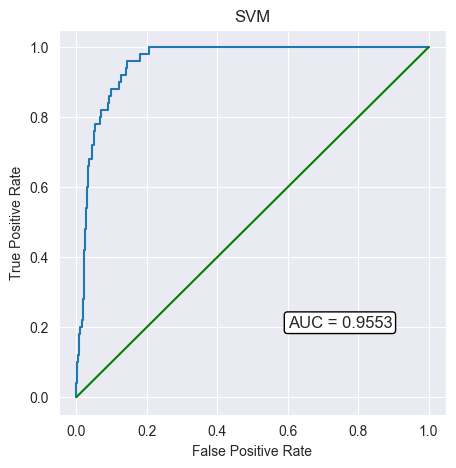

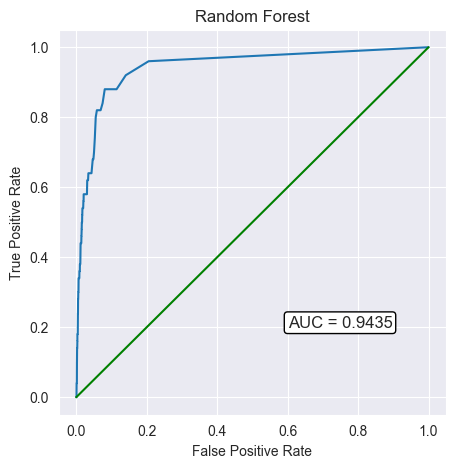

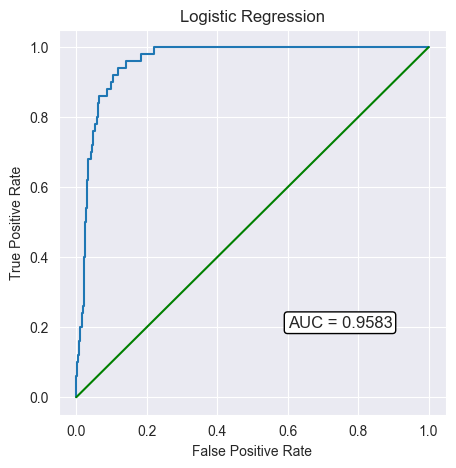

<Figure size 1000x600 with 0 Axes>

In [107]:
from sklearn.metrics import roc_auc_score

# Oversample and plot imbalanced dataset with SMOTE
data_transformed =  data_converted.to_numpy()
X = data_transformed[:, :-1]
y = data_transformed[:, -1].astype(int)

pipe = Pipeline([('scaler', StandardScaler())])
Xt = pipe.fit_transform(X, y)

random_state = 200

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=random_state)
print("Finished processing data")

data = SMOTE(random_state=np.random.RandomState(random_state), k=5, sampling_strategy=0.999).fit_resample(X_train, y_train) #My Smote
X_res, y_res = data

print('After applying smote we have: ')
print('Number of samples with label 0:', len(np.where(y_res == 0)[0]))
print('Number of samples with label 1:', len(np.where(y_res == 1)[0]))

t = Trainer()
t.train_svc_rf_lr_classifiers(X_res, y_res)
t.plot(X_test, y_test)

### 2b. Analyse the performance of the classifiers. Explain which method performs best.

I choose 3 classifiers, as you seen in the image above.Namely, SVM , Random Forest and Logistic Regression. Typically, the closer the corner points is to point (0.0, 1.0) the better it is for the classifier. This is because it is a pot of the true positive rate against the false positive rate. You have to maximimize the True positive rate while minimizing the false positive rate implying that (1,0) is indeed maximal. This is perhaps, better visualized, if you consider the image below:

<img src="images/Roc_curve.png" >


The image shows that the straight line from 0.0 to 1.0 is a random classifier anything above that threshold makes is a better classifier. All 3 classifiers seem to have performed relative well, (Note that SMOTE was only applied to the trainin set to get an unbiased evaluation on the Test set). Out of all 3 classifiers, it seems that Logistic Regression did best as it is closer to one, this is a bit harder to see. Therefore, I also calculated the AUC(area under the curve). AUC captures the area under the curve and compares the realtion with the True Positive Rate and False positive rate. As you can see from the graphs above, Logistic Regression  performs best with an AUC of 0.9583.



### 2c. Is using SMOTE a good idea? Why (not)?

In this exercise using Smote seems to have a negligble effect. To see why, lets look at training it with the same algorithms but without applying smote, below.

Finished processing data
without smote we have: 
Number of samples with label 0: 151476
Number of samples with label 1: 226
Finished training on SVC
Finished training on RFC
Finished training on LR


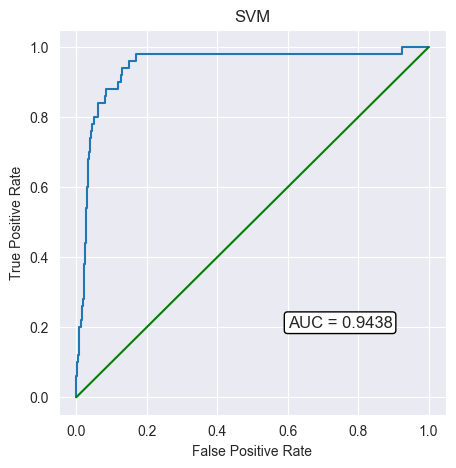

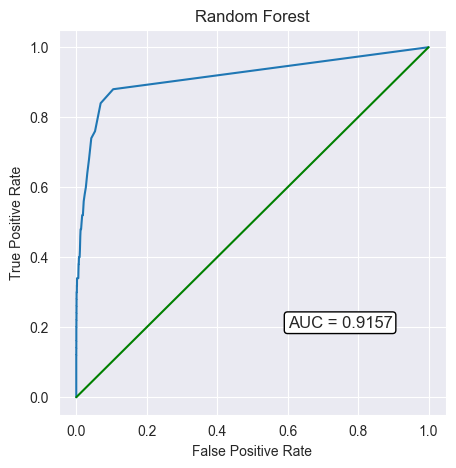

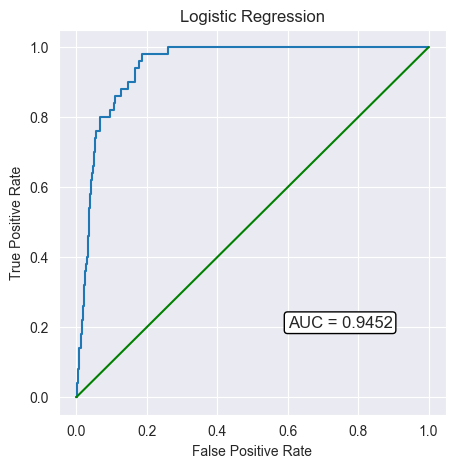

<Figure size 1000x600 with 0 Axes>

In [108]:
data_transformed =  data_converted.to_numpy()
X = data_transformed[:, :-1]
y = data_transformed[:, -1].astype(int)

pipe = Pipeline([('scaler', StandardScaler())])
Xt = pipe.fit_transform(X, y)
random_state = 200

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=random_state)
print("Finished processing data")

print('without smote we have: ')
print('Number of samples with label 0:', len(np.where(y_train == 0)[0]))
print('Number of samples with label 1:', len(np.where(y_train == 1)[0]))

t = Trainer()
t.train_svc_rf_lr_classifiers(X_train, y_train)
t.plot(X_test, y_test)

The AUC scores the plot shows that without smore the classifiers are performing quite well. However, it is indeed true that SMOTE increases the AUC score a bit, for instance logistic regression was increased to 0.9583, SVM to 0.9553 and Random forest to 0.9435. The greatest increase was from  Random forest with a 3% increase. I initially expected SMOtING to give a tremendous increase, but this was not really the case. Note that I applied smote after standardisation step using preprocessing, this centered all features with mean 0 and standrd deviation 1 correcting for feature scaled. That said, applying smote as an oversampling technique is good for unbalanced data. But several papers point out that undersamplign the majority class is much better than oversampling the minority class. It is also important to note that we used a default k of 5, but perhaps using a different k will give much more better results. But it does improve a bit on the auc and roc curves, so I did not tune the k or the sampling strategy as in conclusion it does improve but not as much.

## 3. Privacy task – 1 A4 – Individual

In [109]:
def rank_swap(data, p, random_state=None):
    """
    Rank swapping for a given dataset.

    Parameters:
    data (list of lists): The dataset.
    p (int): The number of rows to consider when selecting a row to swap.

    Returns:
    data (list of lists): The dataset with rank swapped rows.
    """

    data = np.array(data)
    # Get the number of attributes and rows in the dataset.
    num_attrs = data.shape[1]
    num_rows = data.shape[0]

    rng = np.random.default_rng(random_state)

    # For each attribute...
    for i in range(num_attrs):
        # Get the sorted indices
        sorted_indices = np.argsort(data[:, i])
        sorted_data = data[sorted_indices, i]

        # For each row...
        for j in range(num_rows):
            p_min = max(0, j - p)
            p_max = min(num_rows - 1, j + p)

            # Select a row to swap with
            r_prime = rng.integers(p_min, p_max+1)

            # Swap the actual values in the sorted data
            sorted_data[j], sorted_data[r_prime] = sorted_data[r_prime], sorted_data[j]

        # Assign sorted and swapped data back to the original dataset
        data[sorted_indices, i] = sorted_data

    return data[:, :-1], data[:, -1]


### 3a. Print ROC curves

Finished processing data
Finished training on SVC
Finished training on RFC
Finished training on LR


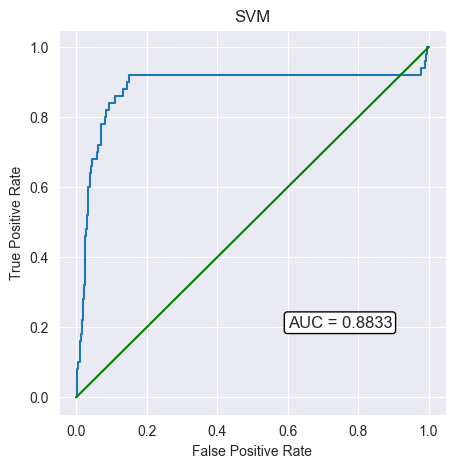

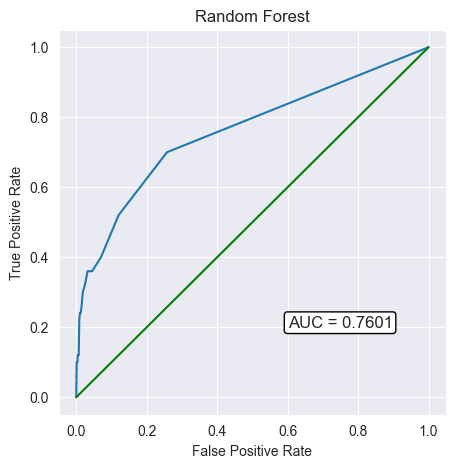

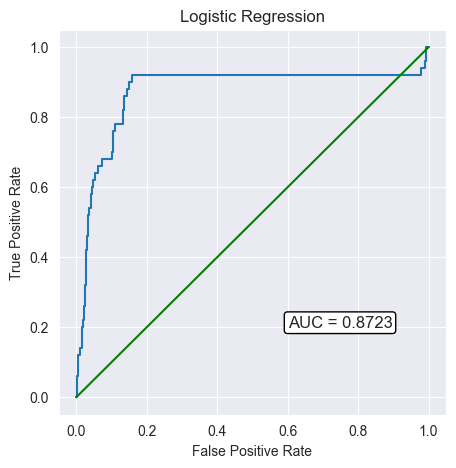

<Figure size 1000x600 with 0 Axes>

In [110]:
data_transformed =  data_converted.to_numpy()
X = data_transformed[:, :-1]
y = data_transformed[:, -1].astype(int)

pipe = Pipeline([('scaler', StandardScaler())])
Xt = pipe.fit_transform(X, y)
random_state = 200

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=random_state)
print("Finished processing data")

data = np.column_stack((X_train, y_train))

X_res, y_res = rank_swap(data, p= 1000, random_state=random_state)
t = Trainer()
t.train_svc_rf_lr_classifiers(X_res, y_res)
t.plot(X_test, y_test)

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

I achieved the above performance with a p value of 1000 which means for each row i swapped with another row within 1000 rows. The graphs show that the performance has greatly decreased for random forest from 0.91 all the way down to 0.76. Note that 1000 as a p value is just 1% of the total number of rows, it shows that eventhough rank swapping keeps the statistical characteristics data and masks the privacy, it can have a detrimental effect on the performance. For k = 1000, the best performing classifier was SVM with a AUC of 0.8833. However, for a thorough evaluation lets vary k and look at the performance.

Finished training on SVC
Finished training on RFC
Finished training on LR
Finished training on SVC
Finished training on RFC
Finished training on LR
Finished training on SVC
Finished training on RFC
Finished training on LR
Finished training on SVC
Finished training on RFC
Finished training on LR
Finished training on SVC
Finished training on RFC
Finished training on LR
Finished training on SVC
Finished training on RFC
Finished training on LR
Finished training on SVC
Finished training on RFC
Finished training on LR
Finished training on SVC
Finished training on RFC
Finished training on LR
Finished training on SVC
Finished training on RFC
Finished training on LR
Finished training on SVC
Finished training on RFC
Finished training on LR
Finished training on SVC
Finished training on RFC
Finished training on LR


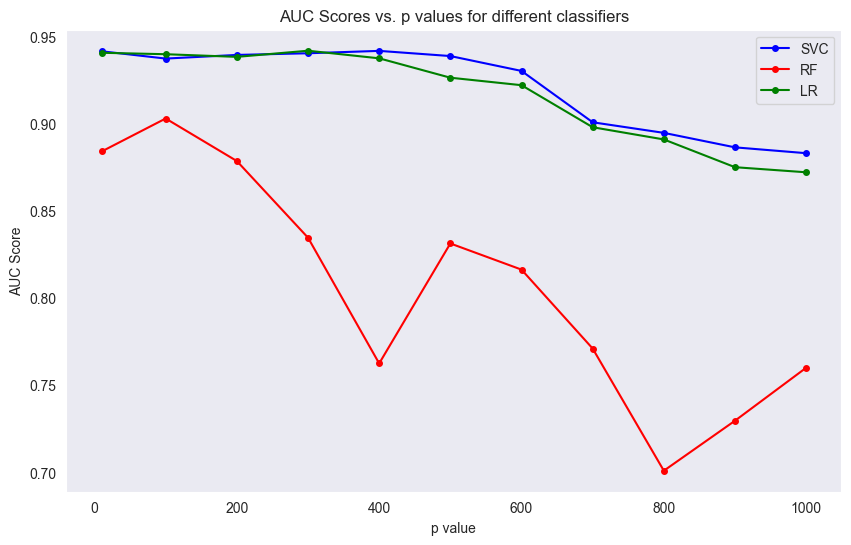

In [111]:
import multiprocessing
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


# The list of p values
p_values = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
auc_scores_svc=[]
auc_scores_rf=[]
auc_scores_lr=[]

for p in p_values:
    X_res, y_res = rank_swap(data, p=p, random_state=random_state)
    t = Trainer()
    t.train_svc_rf_lr_classifiers(X_res, y_res)

    score_svc,score_rf, score_lr  = t.get_auc(X_test, y_test)

    # Compute the AUC score for each classifier and add it to the respective list
    auc_scores_svc.append(score_svc)
    auc_scores_rf.append(score_rf)
    auc_scores_lr.append(score_lr)

# Plotting
plt.figure(figsize=(10,6))

plt.plot(p_values, auc_scores_svc, marker='o', markersize=4, color='blue', label='SVC')
plt.plot(p_values, auc_scores_rf, marker='o', markersize=4, color='red', label='RF')
plt.plot(p_values, auc_scores_lr, marker='o', markersize=4, color='green', label='LR')

plt.title('AUC Scores vs. p values for different classifiers')
plt.xlabel('p value')
plt.ylabel('AUC Score')
plt.legend()
plt.grid()
plt.show()


### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

I would say it depends on how the p value. As you can see from the graph above as the p value increases the performance decreases too. For SVC and LR there is a 0.5 decrease while the decrease is exponential for random forest. Do note that 1000 fore p value is just 1% of the total number of rows, therefore for p values such as 10000 where you have more randomness and privacy obfuscation but very bad performance.

## 4. Classification task – 2 A4

### 4a. Print relevant plots and metrics with clear headings.

Finished processing data


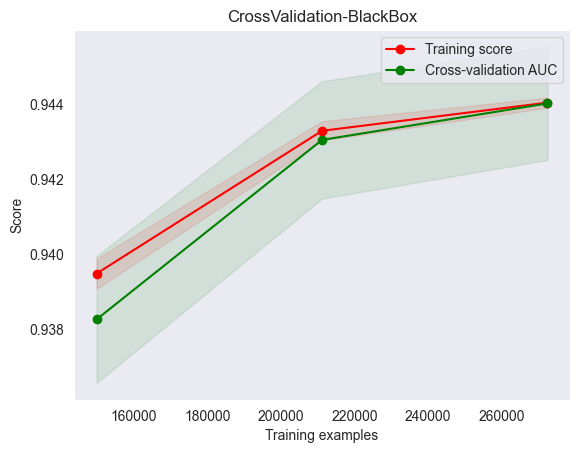

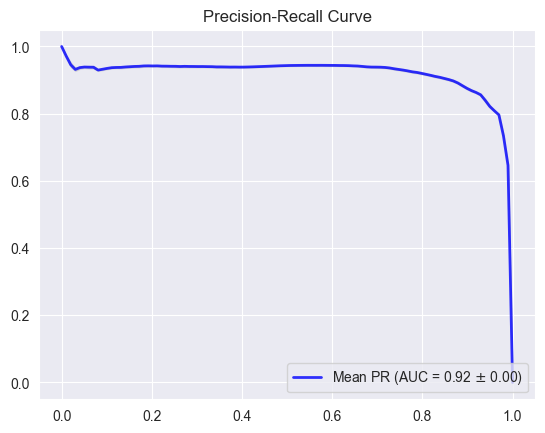

Average F1 score:  0.886188630933669


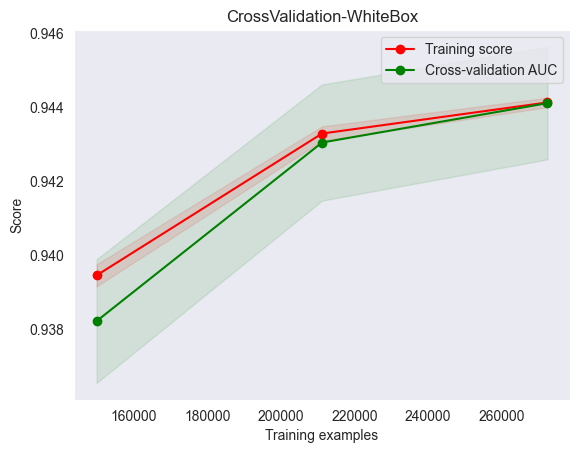

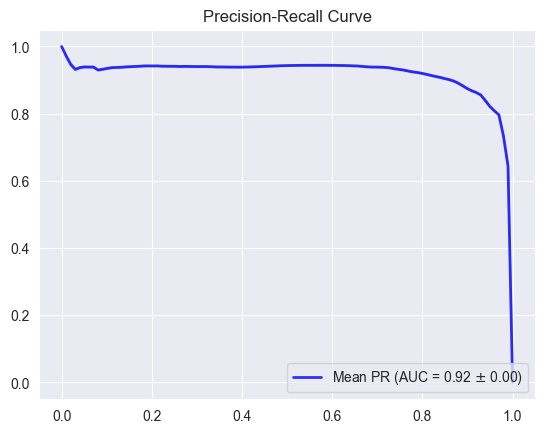

Average F1 score:  0.8861790922861005


In [112]:

from sklearn.ensemble import BaggingClassifier

data_transformed =  data_converted.to_numpy()
X = data_transformed[:, :-1]
y = data_transformed[:, -1].astype(int)

pipe = Pipeline([('scaler', StandardScaler())])
Xt = pipe.fit_transform(X, y)
random_state = 200

oversample = SMOTE(sampling_strategy=0.999)
X_res, y_res = oversample.fit_resample(X_train, y_train)

print("Finished processing data")
t = Trainer(200)
t.cross_validate_auc('CrossValidation-BlackBox',t.black_box, X_res, y_res)
t.cross_validate_auc('CrossValidation-WhiteBox',t.white_box, X_res, y_res)


### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

## 5. Bonus task – 1 A4

### 5a. Provide code and report below

**KAGGLE**

In [113]:
data_transformed =  data_converted.to_numpy()
X = data_transformed[:, :-1]
y = data_transformed[:, -1].astype(int)

pipe = Pipeline([('scaler', StandardScaler())])
Xt = pipe.fit_transform(X, y)
random_state = 200
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=random_state)
oversample = SMOTE(sampling_strategy=0.999)
X_res, y_res = oversample.fit_resample(X_train, y_train)

print("Finished processing data")
t = Trainer()
t.train_black_box(X_res, y_res)
t.get_block_box_auc(X_test, y_test)


Finished processing data


0.9582474390115112